In [1]:
import sys
sys.path.append('/u/ajagadish/ermi/functionlearning/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

from plots import plot_functionlearning_data_statistics, proportion_function_types, model_errors_function_types, model_comparison_little2024, model_extrapolation_delosh1997

In [40]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, warnings, time
FONTSIZE=13
plt.rcParams.update({"font.size":FONTSIZE})
mode = 0
# set env_name and color_stats based on mode
if mode == 0:
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
    color_stats = '#405A63'  # '#2F4A5A'# '#173b4f'
elif mode == 1:  
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
    color_stats = '#66828F'  # 5d7684'# '#5d7684'
elif mode == 2: 
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/real_data_dim1_methodrandom_lichtenberg2017.csv'
    color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'

first=True
plot_df=pd.read_csv(env_name)
max_tasks = 1000
tasks = range(0, max_tasks) if first else np.random.choice(plot_df.task_id.unique(), max_tasks, replace=False)
plot_df = plot_df[plot_df['task_id'].isin(tasks)]
plot_df["input"]=plot_df["input"].apply(lambda v: eval(str(v))[0] if isinstance(v,str) else v)
plot_df["target"]=plot_df["target"].apply(lambda v: eval(str(v))[0] if isinstance(v,str) else v)
plot_df["input"]=plot_df.groupby("task_id")["input"].transform(lambda x:x/np.abs(x).max() if x.max()!=0 else x)
plot_df["target"]=plot_df.groupby("task_id")["target"].transform(lambda x:x/np.abs(x).max() if x.max()!=0 else x)


def bic(sse,n,k):
    if sse<=0 or n<=k: return np.inf
    return k*math.log(n)+n*math.log(sse/n)

def safe_polyfit(x,y,deg):
    try:
        return np.polyfit(x,y,deg)
    except Exception:
        raise
def bic_linear(x,y):
    try:
        a,b=safe_polyfit(x,y,1)
        sse=np.sum((y-(a*x+b))**2)
        return bic(sse,len(x),2),(a,b)
    except Exception:
        return np.inf,(np.nan,np.nan)
def bic_quad(x,y):
    if len(np.unique(x))<2: return np.inf,(np.nan,np.nan)
    try:
        X=np.vstack([x**2,np.ones_like(x)]).T
        a,c=np.linalg.lstsq(X,y,rcond=None)[0]
        sse=np.sum((y-(a*x**2+c))**2)
        return bic(sse,len(x),2),(a,c)
    except Exception:
        return np.inf,(np.nan,np.nan)
def bic_exp(x,y):
    d0=y.min()*0.95
    ys=y-d0
    if np.any(ys<=0): return np.inf,(np.nan,np.nan,np.nan)
    try:
        b,lnA=safe_polyfit(x,np.log(ys),1)
        a=np.exp(lnA); sse=np.sum((y-(a*np.exp(b*x)+d0))**2)
        return bic(sse,len(x),3),(a,b,d0)
    except Exception:
        return np.inf,(np.nan,np.nan,np.nan)
    
freqs=[2*np.pi*k for k in range(1,5)]
def bic_per(x,y):
    best=np.inf; params=(np.nan,np.nan,np.nan)
    for w in freqs:
        try:
            sin=np.sin(w*x); X=np.vstack([sin,np.ones_like(x)]).T
            a,d=np.linalg.lstsq(X,y,rcond=None)[0]
            sse=np.sum((y-(a*sin+d))**2)
            val=bic(sse,len(x),3)
            if val<best: best,params=val,(a,w,d)
        except Exception:
            continue
    return best,params

bic_map={"linear":bic_linear,"quadratic":bic_quad,"exponential":bic_exp,"periodic":bic_per}
records=[]; linear_coeffs=[]
warnings.filterwarnings("ignore")
for tid,g in plot_df.groupby("task_id"):
    x=g["input"].values.astype(float); y=g["target"].values.astype(float)
    if len(x)<2: continue
    best=np.inf; m=None; prm=(np.nan,np.nan,np.nan)
    for name,fn in bic_map.items():
        val,pars=fn(x,y)
        if val<best:
            best=val; m=name; prm=pars
    records.append((tid,m,best)+prm)
    if m=="linear": linear_coeffs.append(prm)

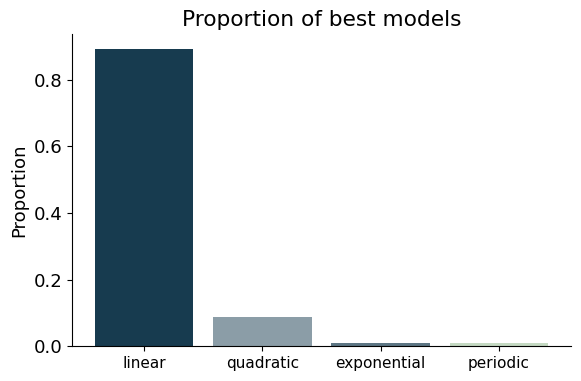

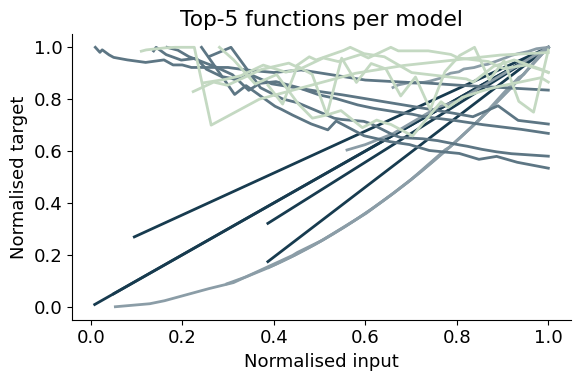

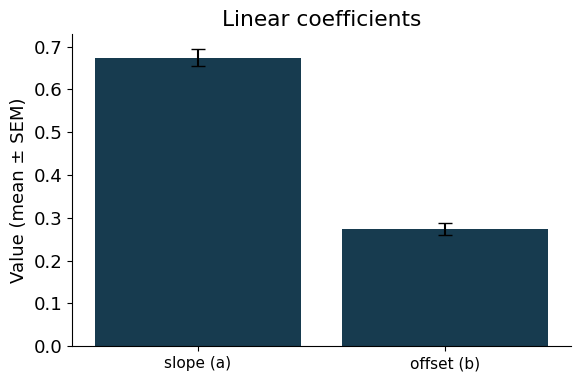

In [41]:
functions=["linear","quadratic", "exponential", "periodic"]
colors=["#173b4f","#8b9da7",'#5d7684', '#c4d9c2'][:len(functions)]
model_df=pd.DataFrame(records,columns=["task_id","model","bic","p1","p2","p3"])
props=model_df["model"].value_counts(normalize=True).reindex(functions,fill_value=0)
plt.figure(figsize=(6,4))
pos=np.arange(len(functions))*0.6
plt.bar(pos,props.values,color=colors,width=0.5)
plt.xticks(pos,functions,fontsize=FONTSIZE-2); plt.ylabel("Proportion"); plt.title("Proportion of best models"); sns.despine(); plt.grid(False); plt.tight_layout(); plt.show()

# overlay plot
plt.figure(figsize=(6,4))
n_best=5
for idx,model in enumerate(functions):
    top=model_df[model_df["model"]==model].nsmallest(n_best, "bic")
    for tid in top["task_id"]:
        g=plot_df[plot_df["task_id"]==tid]
        xs=g["input"].values.astype(float); ys=g["target"].values.astype(float)
        ord=np.argsort(xs); plt.plot(xs[ord],ys[ord],color=colors[idx],lw=2)
plt.xlabel("Normalised input"); plt.ylabel("Normalised target"); plt.title(f"Top‑{n_best} functions per model"); plt.grid(False);  sns.despine(); plt.tight_layout(); plt.show()
# linear coeffs plot
if linear_coeffs:
    slopes=np.array([t[0] for t in linear_coeffs if not np.isnan(t[0])])
    offs=np.array([t[1] for t in linear_coeffs if not np.isnan(t[1])])
    means=[slopes.mean(),offs.mean()]; stds=[slopes.std(ddof=1)/np.sqrt(len(slopes)),offs.std(ddof=1)/np.sqrt(len(slopes))]
    plt.figure(figsize=(6,4))
    xp=np.arange(2)*0.6; plt.bar(xp,means,yerr=stds,width=0.5,color=colors[0],capsize=5)
    plt.xticks(xp,["slope (a)","offset (b)"],fontsize=FONTSIZE-2)
    plt.ylabel("Value (mean ± SEM)"); plt.title("Linear coefficients"); plt.grid(False); sns.despine(); plt.tight_layout(); plt.show()

In [5]:
 datasets = torch.load('/u/ajagadish/ermi/functionlearning/data/generated_tasks/lichtenberg2017.pth')

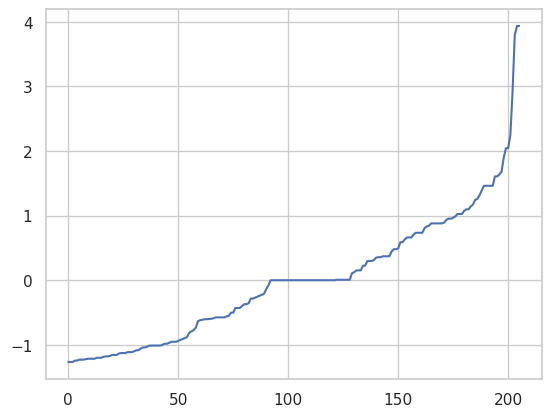

In [13]:
plt.plot(range(len(datasets[0][1])), datasets[0][1].sort()[0])

In [64]:
env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017'
color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'

# Load the dataset
df = pd.read_csv(f'{env_name}.csv')
# max_tasks = 750 #1000
# tasks = np.random.choice(df.task_id.unique(), max_tasks, replace=False)
# df = df[df['task_id'].isin(tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
df['target'] = df['target'].apply(lambda x: eval(x)[0])
df_old = df.copy(deep=True)
# max normalize the input and target columns
# df['input'] = df.groupby('task_id')['input'].transform(lambda x: x / x.max())
# df['target'] = df.groupby('task_id')['target'].transform(lambda x: x / x.max())
df['input'] = df.groupby('task_id')['input'].transform(lambda x: x / np.abs(x).max() if x.max() != 0 else x)
df['target'] = df.groupby('task_id')['target'].transform(lambda x: x / np.abs(x).max() if x.max() != 0 else x)
df = df.sort_values(by=['task_id', 'input'])

In [65]:
mode=2
df = df.sort_values(by=['task_id', 'input'])
# if mode == 2:
#     df = df.groupby('task_id').apply(lambda x: x.sample(100)).reset_index(drop=True)
# df = df.sort_values(by=['task_id', 'input'])

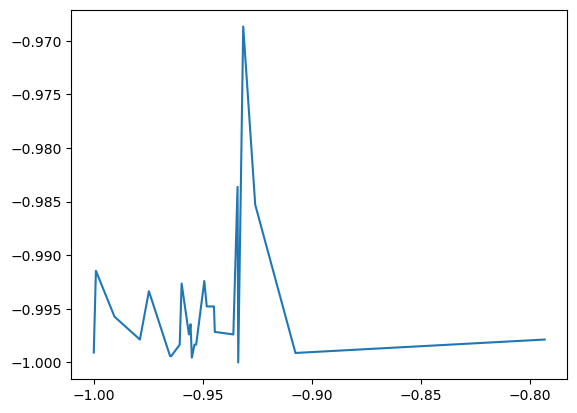

In [89]:
task_id = 1034
plt.plot(df[df.task_id==task_id].input[:25], df[df.task_id==task_id].target[:25]);

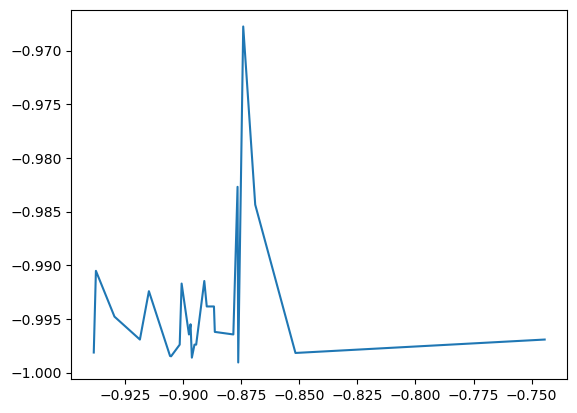

In [90]:
mode=2
df_old = df_old.sort_values(by=['task_id', 'input'])
plt.plot(df_old[df_old.task_id==task_id].input, df_old[df_old.task_id==task_id].target)